## Preambule

In [2]:
# General packages
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import xarray as xr
import pandas as pd
import json
import plotly

# Plotting
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.colors import n_colors

## Parameters

In [3]:
standard_settings = dict(Risk=0.5,
                         Convergence_year=2050)
params = dict(start_year_analysis=2021)
rules = ['GF', 'PC', 'PCC', 'ECPC', 'AP', 'GDR']
rulecolors = ['steelblue', 'goldenrod', 'forestgreen', 'sienna', 'mediumvioletred']
costoptimal_colors = ['orangered', 'red', 'darkred']

## Paths

In [4]:
path_main = Path("X:/user/dekkerm/Projects/ECEMF_T5.2/")
path_data = Path("K:/ECEMF/T5.2/")
path_data_ext = Path("K:/ECEMF/T5.2/")
path_figs = path_main / "Figures" / "ECEMF_paper"

## Read data files

In [5]:
xr_dataread = xr.open_dataset(path_data / "xr_dataread.nc")
xr_bud15 = xr.open_dataset(path_data / "xr_uncbudget_15.nc")
xr_traj_2030 = xr.open_dataset(path_data / "xr_alloc_2030.nc")
xr_traj_2040 = xr.open_dataset(path_data / "xr_alloc_2040.nc")
xr_total = xr.open_dataset(path_data / "xr_policyscen.nc")

all_regions_iso = np.load(path_data / "all_regions.npy")
all_regions_names = np.load(path_data / "all_regions_names.npy")
all_countries_iso = np.load(path_data / "all_countries.npy", allow_pickle=True)
all_countries_names = np.load(path_data / "all_countries_names.npy", allow_pickle=True)

## Get Cost-optimal output

In [6]:
df_ar6 = pd.read_csv("X:/user/dekkerm/Data/IPCC/AR6_ISO3/AR6_Scenarios_Database_ISO3_v1.1.csv")
df_ar6 = df_ar6[df_ar6.Variable.isin(['Emissions|Kyoto Gases', 'Policy Cost|Consumption Loss'])]
df_ar6 = df_ar6.reset_index(drop=True)

df_ar6_meta = pd.read_excel("X:/user/dekkerm/Data/IPCC/AR6_ISO3/AR6_Scenarios_Database_metadata_indicators_v1.1.xlsx", sheet_name='meta_Ch3vetted_withclimate')
mods = np.array(df_ar6_meta.Model)
scens = np.array(df_ar6_meta.Scenario)
modscens_meta = np.array([mods[i]+'|'+scens[i] for i in range(len(scens))])
df_ar6_meta['ModelScenario'] = modscens_meta
df_ar6_meta = df_ar6_meta[['ModelScenario', 'Category', 'Policy_category']]
df_ar6_meta = df_ar6_meta[df_ar6_meta.Category.isin(['C1', 'C2'])]
df_ar6_meta = df_ar6_meta.reset_index(drop=True)
ms_meta_refined = np.array(df_ar6_meta.ModelScenario)

mods = np.array(df_ar6.Model)
scens = np.array(df_ar6.Scenario)
modscens = np.array([mods[i]+'|'+scens[i] for i in range(len(scens))])
df_ar6['ModelScenario'] = modscens
df_ar6 = df_ar6.drop(['Model', 'Scenario', 'Unit'], axis=1)
df_ar6 = df_ar6[df_ar6.ModelScenario.isin(np.array(ms_meta_refined))]

dummy = df_ar6.melt(id_vars=["Variable", "Region", "ModelScenario"], var_name="Time", value_name="Value")
dummy['Time'] = np.array(dummy['Time'].astype(int))
dummy = dummy.set_index(["Variable", "Region", "ModelScenario", "Time"])
xr_scen_r = xr.Dataset.from_dataframe(dummy)
xr_scen_r = xr_scen_r.reindex(Time = np.arange(1850, 2101))
xr_scen_r = xr_scen_r.interpolate_na(dim="Time", method="linear")

In [24]:
cost_opt = xr_scen_r.sel(Variable='Emissions|Kyoto Gases', Time=2040)/xr_scen_r.sel(Variable='Emissions|Kyoto Gases', Time=2040)*xr_scen_r.sel(Variable='Emissions|Kyoto Gases', Time=2040)

## Compute fractions

In [28]:
xr_larger_than_costopt = xr_traj_2040.sel(Temperature=1.5, Convergence_year=2050, Risk=0.5).median(dim=['Scenario', "NegEmis", "TrajUnc"]) > cost_opt.mean(dim='ModelScenario').Value

In [30]:
# costopt = budgets.mean(dim='ModelScenario').Value
# rules = ['GF', 'PC', 'PCC', 'ECPC', 'AP', 'GDR']
# for rule_i, rule in enumerate(rules):
#     buds = xr_bud15.sum(dim='Time').sel(Risk=0.5, Convergence_year=2050).mean(dim='Scenario')
#     if rule_i == 0: larger_than_costopt = costopt.where(costopt > buds, 0).where(costopt<=buds, 1).where(~np.isnan(costopt), np.nan)
#     else: larger_than_costopt += costopt.where(costopt > buds, 0).where(costopt<=buds, 1).where(~np.isnan(costopt), np.nan)

World

In [31]:
df_ar6 = pd.read_csv("X:/user/dekkerm/Data/IPCC/AR6_Scenarios_Database_World_v1.1.csv")
df_ar6 = df_ar6[df_ar6.Variable.isin(['Emissions|Kyoto Gases', 'Policy Cost|Consumption Loss'])]
df_ar6 = df_ar6.reset_index(drop=True)

df_ar6_meta = pd.read_excel("X:/user/dekkerm/Data/IPCC/AR6_Scenarios_Database_metadata_indicators_v1.1.xlsx", sheet_name='meta_Ch3vetted_withclimate')
mods = np.array(df_ar6_meta.Model)
scens = np.array(df_ar6_meta.Scenario)
modscens_meta = np.array([mods[i]+'|'+scens[i] for i in range(len(scens))])
df_ar6_meta['ModelScenario'] = modscens_meta
df_ar6_meta = df_ar6_meta[['ModelScenario', 'Category', 'Policy_category']]
df_ar6_meta = df_ar6_meta[df_ar6_meta.Category.isin(['C1', 'C2'])]
df_ar6_meta = df_ar6_meta.reset_index(drop=True)
ms_meta_refined = np.array(df_ar6_meta.ModelScenario)

mods = np.array(df_ar6.Model)
scens = np.array(df_ar6.Scenario)
modscens = np.array([mods[i]+'|'+scens[i] for i in range(len(scens))])
df_ar6['ModelScenario'] = modscens
df_ar6['Region'] = 'WORLD'
df_ar6 = df_ar6.drop(['Model', 'Scenario', 'Unit'], axis=1)
df_ar6 = df_ar6[df_ar6.ModelScenario.isin(np.array(ms_meta_refined))]

dummy = df_ar6.melt(id_vars=["Variable", "Region", "ModelScenario"], var_name="Time", value_name="Value")
dummy['Time'] = np.array(dummy['Time'].astype(int))
dummy = dummy.set_index(["Variable", "Region", "ModelScenario", "Time"])
xr_scen = xr.Dataset.from_dataframe(dummy)
xr_scen = xr_scen.reindex(Time = np.arange(1850, 2101))
xr_scen = xr_scen.interpolate_na(dim="Time", method="linear")

Regional

In [32]:
df_ar6 = pd.read_csv("X:/user/dekkerm/Data/IPCC/AR6_ISO3/AR6_Scenarios_Database_ISO3_v1.1.csv")
df_ar6 = df_ar6[df_ar6.Variable.isin(['Emissions|Kyoto Gases', 'Policy Cost|Consumption Loss'])]
df_ar6 = df_ar6.reset_index(drop=True)

df_ar6_meta = pd.read_excel("X:/user/dekkerm/Data/IPCC/AR6_ISO3/AR6_Scenarios_Database_metadata_indicators_v1.1.xlsx", sheet_name='meta_Ch3vetted_withclimate')
mods = np.array(df_ar6_meta.Model)
scens = np.array(df_ar6_meta.Scenario)
modscens_meta = np.array([mods[i]+'|'+scens[i] for i in range(len(scens))])
df_ar6_meta['ModelScenario'] = modscens_meta
df_ar6_meta = df_ar6_meta[['ModelScenario', 'Category', 'Policy_category']]
df_ar6_meta = df_ar6_meta[df_ar6_meta.Category.isin(['C1', 'C2'])]
df_ar6_meta = df_ar6_meta.reset_index(drop=True)
ms_meta_refined = np.array(df_ar6_meta.ModelScenario)

mods = np.array(df_ar6.Model)
scens = np.array(df_ar6.Scenario)
modscens = np.array([mods[i]+'|'+scens[i] for i in range(len(scens))])
df_ar6['ModelScenario'] = modscens
df_ar6 = df_ar6.drop(['Model', 'Scenario', 'Unit'], axis=1)
df_ar6 = df_ar6[df_ar6.ModelScenario.isin(np.array(ms_meta_refined))]

dummy = df_ar6.melt(id_vars=["Variable", "Region", "ModelScenario"], var_name="Time", value_name="Value")
dummy['Time'] = np.array(dummy['Time'].astype(int))
dummy = dummy.set_index(["Variable", "Region", "ModelScenario", "Time"])
xr_scen_r = xr.Dataset.from_dataframe(dummy)
xr_scen_r = xr_scen_r.reindex(Time = np.arange(1850, 2101))
xr_scen_r = xr_scen_r.interpolate_na(dim="Time", method="linear")

Concatenate

In [33]:
xr_scen_all = xr.merge([xr_scen, xr_scen_r])

## Plot

In [34]:
path_ctygroups = "X:/user/dekkerm/Data/" + "UNFCCC_Parties_Groups_noeu.xlsx"
df = pd.read_excel(path_ctygroups, sheet_name = "Country groups")
countries_iso = np.array(df["Country ISO Code"])
countries_name = np.array(df["Name"])
countries_iso = np.array(df["Country ISO Code"])
group_eu = countries_iso[np.array(df["EU"]) == 1]

Helper stuff

In [35]:
colmap = 'Earth_r'
colmap2 = 'terrain_r'

In [36]:
regs = xr_larger_than_costopt.Region#np.array(larger_than_costopt.Region)[np.where(~np.isnan(larger_than_costopt))]
data = []
for cty_i, cty in enumerate(regs):
    data.append(np.sum([float(xr_larger_than_costopt.sel(Region=cty)[i]) for i in rules]))
    #larger_than_costopt.sel(Region=regs)/6
data = (6-np.array(data))/6

Actual plot

In [40]:
fig = make_subplots(rows=5, cols=4, 
                    specs=[[{'type': 'choropleth', 'colspan': 3, 'rowspan': 3}, {}, {}, {}],
                           [{}, {}, {}, {}],
                           [{}, {}, {}, {}],
                           [{}, {}, {}, {}],
                           [{'colspan': 4}, {}, {}, {}]],
                    horizontal_spacing = 0.05, vertical_spacing=0.08)

fig.add_trace(
    go.Choropleth(
    locations=regs,
    z = data,
    locationmode = 'ISO-3',
    colorscale = colmap,
    zmax = 1,
    zmin = 0,
    text = [str(r)+": "+str(int(data[r_i]*6))+" out of 6" for r_i, r in enumerate(np.array(regs))],
    hovertemplate  = '%{text}',
    name="",
    marker_line_color='black', 
    marker_line_width=1.,
    colorbar=dict(len=0.43, x=0.37, y=0.45, orientation='h',
                  tickvals = np.arange(0, 1.1, 1/6),
                  thickness=15,
                  tickfont={'size': 10},
                  ticktext=['None<br>(Mitigation financed<br>by others)', '1 out of 6', '2 out of 6', '3 out of 6', '4 out of 6', '5 out of 6', 'All<br>(Finances mitigation<br>abroad)'],
                  ticklabelposition='outside',
    ),
    showscale=True
), 1, 1)
fig.add_trace(
    go.Choropleth(
    locations=group_eu,
    z = [data[np.where(regs == "EU")[0][0]]]*len(group_eu),
    locationmode = 'ISO-3',
    colorscale = colmap,
    zmax = 1,
    zmin = 0,
    text = ["EU: "+str(int(6*data[regs == 'EU']))+" out of 6"for r_i, r in enumerate(group_eu)],
    hovertemplate  = '%{text}',
    name="",
    marker_line_color='black', 
    marker_line_width=1.,
    showscale=False
), 1, 1)
fig.update_geos(showocean=True, oceancolor="aliceblue")
fig.update_geos(showlakes=True, lakecolor="aliceblue")

# limite map scope to USA 'africa', 'asia', 'europe', 'north america', 'south america', 'usa', 'world'
fig.update_geos(visible=True,
                showlakes=False,
                lakecolor='rgb(255, 255, 255)',
                projection_type='natural earth',
                showcoastlines=False,)

values = ['CP', 'NDC', 'NZ', 'CO2_costopt', 'GF', 'PC', 'PCC', 'AP', 'GDR', 'ECPC']
for cty_i, cty in enumerate(["USA", "BRA", "ZAF", "EU", "RUS", "CHN", "IND"]):
    row = [4, 4, 4, 1, 2, 3, 4][cty_i]
    col = [1, 2, 3, 4, 4, 4, 4][cty_i]
    # !!!!! values_co_emis = xr_scen_all.sel(Region=cty, Time=np.arange(params['start_year_analysis'], 2101), Variable='Emissions|Kyoto Gases').Value.sum(dim='Time', skipna=False)
    values_co_emis = xr_scen_all.sel(Region=cty, Time=2040, Variable='Emissions|Kyoto Gases').Value/1e3
    fig.add_trace(go.Scatter(x=['CP', 'NDC', 'NZ', 'CO', 'GF', 'PC', 'PCC', 'AP', 'GDR', 'ECPC'], y=[values_co_emis.median() for val in values], name='', showlegend=False, hoverinfo='skip', mode='lines', line={'color': 'black', 'width': 0}), col=col, row=row)
    fig.add_trace(go.Scatter(x=['CO', 'GF', 'PC', 'PCC', 'AP', 'GDR', 'ECPC'], y=[values_co_emis.median() for val in values], name='', showlegend=False, hoverinfo='skip', mode='lines', line={'color': 'black', 'width': 1}), col=col, row=row)
    fig.add_trace(go.Scatter(x=['GF', 'PC', 'PCC', 'AP', 'GDR', 'ECPC'], y=[values_co_emis.quantile(0.25) for val in values], fill=None, name='', showlegend=False, hoverinfo='skip', mode='lines', line={'color': 'silver', 'width': 0}), col=col, row=row)
    fig.add_trace(go.Scatter(x=['GF', 'PC', 'PCC', 'AP', 'GDR', 'ECPC'], y=[values_co_emis.quantile(0.75) for val in values], fill='tonexty', name='', showlegend=False, hoverinfo='skip', mode='lines', line={'color': 'silver', 'width': 0}), col=col, row=row)
    fig.add_trace(go.Box(y=values_co_emis,
                        name="CO",
                        #text=[cty+": "+str(np.round(vals[i],1))+"<br>"+modscens[i] for i in range(len(vals))],
                        fillcolor=plotly.colors.diverging.Earth_r[int(data[regs == cty][0]*6)],
                        line_color='black', marker=dict(color='grey'),#plotly.colors.diverging.Earth_r[int(fractions[regs == cty][0]*7)]),
                        boxpoints='all', jitter=0.5, pointpos=0, whiskerwidth=0.4, marker_size=0.1, line_width=1.5, showlegend=False, hovertemplate='%{text}'),
                        row=row, col=col)

    # Engage results
    for eng_i, eng in enumerate(['CurPol', 'NDC', 'NetZero']):
        # !!!!! values_eng = xr_total.sel(Time=np.arange(params['start_year_analysis'], 2101), Region=cty).sum(dim='Time', skipna=False)[eng]
        values_eng = xr_total.sel(Time=2040, Region=cty)[eng]/1e3
        fig.add_trace(go.Box(y=values_eng,
                        name=["CP", "NDC", "NZ"][eng_i],
                        fillcolor=plotly.colors.diverging.Earth_r[int(data[regs == cty][0]*6)],
                        line_color='black', marker=dict(color='grey'),
                        boxpoints='all', jitter=0.5, pointpos=0, whiskerwidth=0.4, marker_size=0.1, line_width=1.5, showlegend=False, hovertemplate='%{text}'),
                        row=row, col=col)

    # Full cost optimal emissions (AR6 C1-C2)
    fig.add_trace(go.Box(y=values_co_emis,
                    name="CO",
                    fillcolor=plotly.colors.diverging.Earth_r[int(data[regs == cty][0]*6)],
                    line_color='black', marker=dict(color='grey'),
                    boxpoints='all', jitter=0., pointpos=0, whiskerwidth=0.4, marker_size=0.1, line_width=1.5, showlegend=False, hovertemplate='%{text}'),
                    row=row, col=col)

    # Effort sharing
    for alloc_i, alloc in enumerate(['GF', 'PC', 'PCC', 'AP', 'GDR', 'ECPC']):
        # !!!!! ally = xr_bud15.sel(Region=cty, Risk=0.5, Convergence_year=2050).sum(dim='Time').mean(dim='Scenario')[alloc]
        ally = xr_traj_2040.sel(Region=cty, Risk=0.5, Convergence_year=2050, Temperature=1.5).mean(dim='Scenario')[alloc].median()/1e3
        if ally < values_co_emis.quantile(0.40):
            colr = 'tomato'
            marker = 'triangle-down'
            textpos = 'middle left'
            txt = '-<b>$'
            size = 13
        elif ally > values_co_emis.quantile(0.60):
            colr = 'forestgreen'
            marker = 'triangle-up'
            textpos = 'middle left'
            txt = '+<b>$'
            size = 13
        else:
            colr = 'grey'
            marker = 'square'
            textpos = 'middle left'
            txt = '~<b>$'
            size = 10
        fig.add_trace(go.Scatter(x=[alloc, alloc], y=[values_co_emis.median(), ally], mode='lines', line={'width': 2, 'color': colr, 'dash': 'dot'}, showlegend=False), row=row, col=col)
        fig.add_trace(go.Scatter(x=[alloc], y=[ally], text=txt, textfont={'color': colr}, mode='markers+text', marker={'symbol':marker, "color": colr, "size": size, "line": {"width": 1.5, "color": 'black'}},
                                 showlegend=False, textposition=textpos),
                      row=row, col=col)

y1 = xr_scen_all.sel(Time=np.arange(params['start_year_analysis'], 2101), Variable='Policy Cost|Consumption Loss').Value.sum(dim='Time', skipna=False)
gdp1 = xr_dataread.sel(Time=params['start_year_analysis']).GDP.mean(dim='Scenario')
ar = np.array((y1/gdp1).Region[np.array((y1/gdp1).median(dim='ModelScenario').argsort())])
ar = ar[ar!='WORLD']
for reg_i, reg in enumerate(ar):
    y = xr_scen_all.sel(Region=reg, Time=np.arange(params['start_year_analysis'], 2101), Variable='Policy Cost|Consumption Loss').Value.sum(dim='Time', skipna=False)
    gdp = xr_dataread.sel(Region=reg, Time=params['start_year_analysis']).GDP.mean(dim='Scenario')
    try:
        col = plotly.colors.diverging.Earth_r[int(data[regs == reg][0]*6)]
    except:
        col = 'silver'
    if np.nansum(y) != 0:
        fig.add_trace(go.Box(name=reg, y=y/gdp,
                            line_color='black',
                            marker=dict(color=col),
                            fillcolor=col,
                            boxpoints='all', jitter=0.5, pointpos=-1.8, whiskerwidth=0.4, marker_size=3, line_width=1,
                            showlegend=False), row=5, col=1)

# Panel labels
fig.add_annotation(xref='paper', yref='paper',ax=0, align='left', ay=-0, showarrow=False, font=dict(color='black', size=18),
                   y=1.04, x=0.20, text="<b>(a) Allocations less than cost-optimal</b><br>          (in number of effort-sharing approaches)")
fig.add_annotation(xref='paper', yref='paper',ax=0, align='right', ay=-0, showarrow=False, font=dict(color='black', size=16), y=0.38, x=0.01, text="<b>(b) United States of America")
fig.add_annotation(xref='paper', yref='paper',ax=0, align='right', ay=-0, showarrow=False, font=dict(color='black', size=16), y=0.38, x=0.27, text="<b>(c) Brazil")
fig.add_annotation(xref='paper', yref='paper',ax=0, align='right', ay=-0, showarrow=False, font=dict(color='black', size=16), y=0.38, x=0.60, text="<b>(d) South-Africa")
fig.add_annotation(xref='paper', yref='paper',ax=0, align='right', ay=-0, showarrow=False, font=dict(color='black', size=16), y=1.02, x=0.94, text="<b>(e) European Union")
fig.add_annotation(xref='paper', yref='paper',ax=0, align='right', ay=-0, showarrow=False, font=dict(color='black', size=16), y=0.81, x=0.87, text="<b>(f) Russia")
fig.add_annotation(xref='paper', yref='paper',ax=0, align='right', ay=-0, showarrow=False, font=dict(color='black', size=16), y=0.58, x=0.87, text="<b>(g) China")
fig.add_annotation(xref='paper', yref='paper',ax=0, align='right', ay=-0, showarrow=False, font=dict(color='black', size=16), y=0.38, x=0.87, text="<b>(h) India")
fig.add_annotation(xref='paper', yref='paper',ax=0, align='left', ay=-0, showarrow=False, font=dict(color='black', size=16), y=0.14, x=0.01, text="<b>(i) Policy costs over 2020-2100 in cost-optimal scenarios</b>")

# ADD LINES TO PATHS
fig.update_yaxes(title_text="GHG emission allocations in 2040<br>[Gt CO<sub>2</sub>e]", row=4, col=1)
fig.update_yaxes(title_text="Cumulative consumption<br>loss as fraction<br>of GDP in 2019", row=5, col=1)

fig.update_yaxes(rangemode="tozero")
fig.update_xaxes(zeroline=True, zerolinewidth=2, zerolinecolor='Black')
fig.update_layout(height=1100,
                  width=1400,
                  template='simple_white')
fig.show()

In [41]:
fig.write_image(path_figs / "Figure_4.png", scale=6)

In [42]:
path_cse="C:/Users/dekkerm/Downloads/temperature/temperature/hw_95_3_1p2_abs.nc4"

In [78]:
xr_cse = xr.open_dataset(path_cse)#.hw_95_3_1p2_abs

In [79]:
xr_cse

<xarray.Dataset>
Dimensions:          (lat: 360, lon: 720)
Coordinates:
    stats            object ...
  * lat              (lat) float64 89.75 89.25 88.75 ... -88.75 -89.25 -89.75
  * lon              (lon) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
    percentile       float64 ...
    dt               int32 ...
    threshold        float64 ...
Data variables:
    hw_95_3_1p2_abs  (lat, lon) float64 ...
Attributes:
    name:         hw_95_3_1p2_abs
    description:  Absolute values for cumulative number of days per year, fro...
    citation:     Climate Solutions Explorer - hazard, impacts and exposure d...
    website:      www.climate-solutions-explorer.eu
    doi:          https://doi.org/10.5281/zenodo.7971430
    version:      0.2 (pre-release)
    license:      These datasets are published under the CC BY 4.0 license.
    date:         2023-06-12 11:15:56.939169
    institution:  International Institute for Applied Systems Analysis (IIASA)
    contact:      werning@iiasa.ac.at
    project:      ENGAGE
    project_url:  https://www.engage-climate.org/

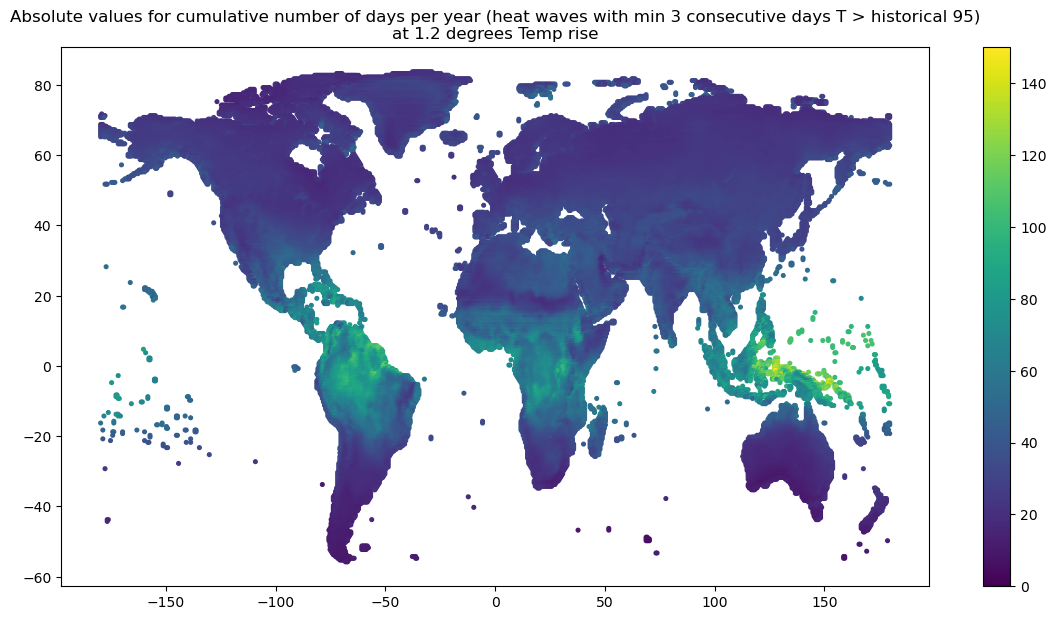

In [77]:
fig, ax = plt.subplots(figsize=(14, 7))
for lat_i, lat in enumerate(np.array(xr_cse.lat)):
    colvals = np.array(xr_cse.sel(lat=lat))
    if len(np.where(~np.isnan(colvals))[0]) != 0:
        plt.scatter(np.array(xr_cse.lon)[~np.isnan(colvals)], np.array([lat]*len(xr_cse.lon))[~np.isnan(colvals)], c=colvals[~np.isnan(colvals)], s=7, vmin=0, vmax=150)
ax.set_title("Absolute values for cumulative number of days per year (heat waves with min 3 consecutive days T > historical 95)"+'\n'+"at 1.2 degrees Temp rise")
plt.colorbar()